<a href="https://colab.research.google.com/github/05-515/stepik_deep_learning/blob/main/4_neural_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение классификатора с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными
В этом видео мы решим задачу бинарной классификации с помощью рекуррентной нейронной сети. Узнаем, как использовать стандартные модули из библиотеки torch  и сравним два подхода к агрегации эмбеддингов: max pooling и простое усреднение.

Занятие ведет Антон Земеров.

In [1]:
!pip install datasets
# этот модуль помогает работать с данными

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('punkt')
#этот пакет нужен для использования токенизатора 

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Подготовка данных

In [5]:
# Загрузим датасет. это 50.000 отзывов с сайта imdb. имеют отметку 1 или 0 (позитивный или негативный отзыв)
dataset = datasets.load_dataset('imdb')

In [6]:
#посчитаем частоту вхождения слов, чтобы составить словарь. для воспользуемся классом Counter
#word_tokenizer функция,чтобы выделить все слова 
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [00:19<00:00, 1283.32it/s]


In [7]:
#специальные служебные слова
#unk - неизвестный токен
#bos - начало последовательности
#eos - конец последовательности
#pad - служебный токен, можем объединять последовательности разной длины в один баш, чтобы сделать его прямоугольным
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25 # добавим в словарь все слова, которые встречались чаще, чем 25 раз. подобрал самостоятельно, чтобы был адекватный размер словаря. можно варьировать смотреть на качество решения задания

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [8]:
len(vocab)

11399

In [9]:
#заведем 2 словаря. означают мапинг слов в индексы и наоборот
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [10]:
# здесь будем хранить нащи примеры и подавать в torch data loader
class WordDataset:
    #конструктор
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']
    #по индексу получаем пример из нашего датасета
    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation)) #возьмем строку self.data/возьмем поле text и удалим всю пунктуацию методом translate, приведем к нижнему регистру 
        tokenized_sentence = [self.bos_id]# начнем составлять нашу токенизаованную последовательность. добавим токен начала строки
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)# для кажого слова, полученного c помощью word_tokenize попробуем достать id слова из word2ind
            ]#если не получается достать, то возвращаем unk_id токена
        # метод get работает так. вначале по ключу пытаемся получить значение. если не находит, то unk_id
        tokenized_sentence += [self.eos_id]#добавляем id конца строки
        #  получили токенизованние предложение с индексами
        #соберем предложение в train_sample. будет токенизованный текст и метка принадлежности к классу
        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample
# dataloader должен понимать какой длины и размера наш датасет
    def __len__(self) -> int:
        return len(self.data)

In [11]:
#собирать последовательности в один батч. это список примеров, который dataloader получил по индексу
#после этого нужно сделать паддинг последовательности, собрать в тензоры и переместить на необходимый девайс
#чтобы западить наш девайс,посчитаем длины всех текстов в нашем батче
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len) # ограничиваем максимальную длину последовательности, по дефолту 256 
    #формируем новый батч последовательности. проходим по входной последовательности, берем текст, ограничиваем макс длиной 
    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    #после того,как получили батч, собираем в отдельный тензор. long tensor содержит целочисленные индексы наших токенов(слов). перемещаем его на девайс
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch #на выходе словарь, который по ключу input_ids будет тензор токенов,а по label тензор меток класса

In [12]:
# в наш dataset добавляем все примеры, которые есть в загруженном датасете imdb
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)# фиксируем сид числом 42, чтобы пр многократном запуске этой ячейки всегда получали один набор выборки
idx = np.random.choice(np.arange(len(dataset['test'])), 2000) #для валидации возмем 2000 случайных примеров.в imdb тестовое множество равно тренировочному = 25000, это много
eval_dataset = WordDataset(dataset['test'].select(idx))
#создали 2 датасета
#создадим dataloader
batch_size = 128
#
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)#хотим перемешивать порядок тренировочной выборки, передадим нашу collate функцию

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)#отличие, не делаем shuffle

## Архитектура модели

In [13]:
class CharLM(nn.Module):
    #в конструкторе определим все слои
    #скрытая размерность, размер словаря,количество классов предсказания
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)#храним матрицу эмбедингов - вектор, соответствующий слову в словаре
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)#определим rnn ьодуль. передаем входуню и выходную последовательность. они одинаковы.
        self.linear = nn.Linear(hidden_dim, hidden_dim)# простая полносвязная сеть из 2 слоев. из скрытой размерности преобразует в скрытую размерность
        self.projection = nn.Linear(hidden_dim, num_classes)#скрытую размерность проектирует в количество классов, чтобы делать предсказания

        self.non_lin = nn.Tanh()#функция активации
        self.dropout = nn.Dropout(p=0.1)#dropout слой c вероятностью 0.1

        self.aggregation_type = aggregation_type
    #посмотрим что внутри форвард
    def forward(self, input_batch) -> torch.Tensor:#получаем входной батч и считаем эмбединги
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] поллучаем rnn блок блок с 3 размерностями. seq_len скрытый слой h
        # сравнить 2 подхода к агрегации. max_pooling
        if self.aggregation_type == 'max':#
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]#по первой размерности берем максимум всех векторов и нулевой элемент. нам нужны только значения, а не индексы, возвращает значения [0]
        elif self.aggregation_type == 'mean':#среднее. берем среднюю по первой размерности
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]#после надо прогнать через полносвязные сети
        #нелинейная-линейная-дрооут-нелинейная- конечное предсказание
        #в конце тензор размера батч сайза класис
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

## Train loop

In [14]:
#последний этап. просто хотим считать точность на валидац датасете. написана для удобства
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
#2 массива 
    predictions = []#предсказание
    target = []#истинное значение
    with torch.no_grad():# не считать градиент на валидации
        for batch in eval_dataloader:# для каждого батча в даталоадере посчитаем предсказание модели
            logits = model(batch['input_ids'])#получим логиты
            predictions.append(logits.argmax(dim=1))#возьмем макс значения, это и будут наши предсказания
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()#доля правильности предсказанных моделей.

    return accuracy

In [15]:
#определим нашу модель, нашу лоссс-функцию
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])#подаем логиты(сырые числа), не приведенные к вероятности
optimizer = torch.optim.Adam(model.parameters())#оптимизатор

In [16]:
#стандартный train-loop для нейросетей
num_epoch = 5#количество эпох
eval_steps = len(train_dataloader) // 2#количество шагов для валидации

#заводим 2 словаря для лосов и значений accurancy
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    #каждый раз заново будем инициилизовавть модель
    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            #делаем стандартные шаги
            optimizer.zero_grad()#обнуляем градиенты
            logits = model(batch['input_ids'])#считаем логиты
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())#считаем лосс функцию
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::  90%|█████████ | 177/196 [02:42<00:17,  1.09it/s]


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


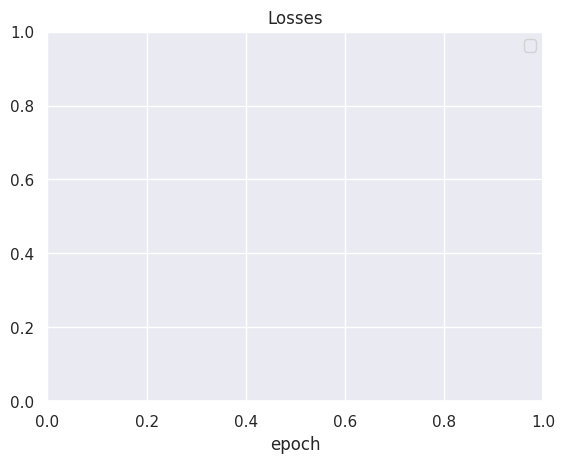

In [17]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


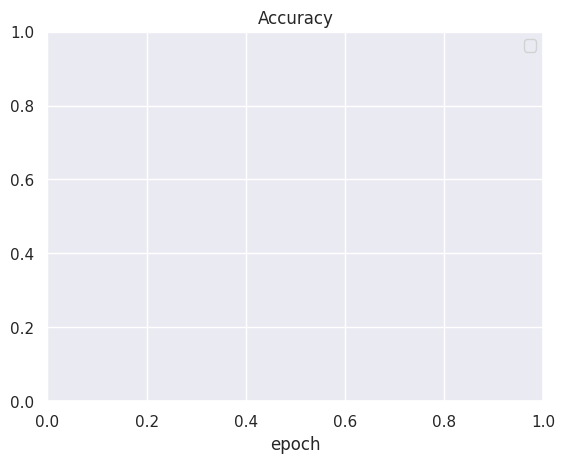

In [18]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()